# **Business Case: Zee Recommender Systems**
The Zee Recommender System project focuses on developing a personalized recommendation engine for movies. By leveraging data on user ratings and viewing preferences, the system identifies patterns and similarities among users to curate movie suggestions tailored to individual tastes. This project simulates the functionality of popular recommendation systems used by streaming platforms, enhancing the overall user experience by delivering relevant and engaging content.

## **Objective:**
To create a personalized movie recommender system that:

- Improves User Engagement: By providing movie recommendations based on a user’s preferences and the viewing habits of similar users.
- Leverages Collaborative Filtering Techniques: Utilize user-user and item-item similarities derived from historical rating data.
- Enhances User Retention: By offering relevant recommendations, keeping users interested in the platform, and encouraging longer watch times.
- Delivers Accurate Predictions: Evaluate the model using performance metrics like RMSE, MAE, and MAPE to ensure high recommendation quality.

## **Dataset Information:**
### **Source:**
  Please check the dataset at:[link](https://drive.google.com/drive/folders/1RY4RG7rVfY8-0uGeOPWqWzNIuf-iosuv)



### **Data Dictionary:**


**RATINGS FILE DESCRIPTION**

- All ratings are contained in the file "ratings.dat" and are in the following format:
UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040

- MovieIDs range between 1 and 3952

- Ratings are made on a 5-star scale (whole-star ratings only)

- Timestamp is represented in seconds

- Each user has at least 20 ratings


**USERS FILE DESCRIPTION**

- User information is in the file "users.dat" and is in the following format:
UserID::Gender::Age::Occupation::Zip-code

- All demographic information is provided voluntarily by the users and is not checked for accuracy.
- Only users who have provided some demographic information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female

- Age is chosen from the following ranges:

  - 1: "Under 18"

  - 18: "18-24"

  - 25: "25-34"

  - 35: "35-44"

  - 45: "45-49"

  - 50: "50-55"

  - 56: "56+"

- Occupation is chosen from the following choices:

  - 0: "other" or not specified

  - 1: "academic/educator"

  - 2: "artist"

  - 3: "clerical/admin"

  - 4: "college/grad student"

  - 5: "customer service"

  - 6: "doctor/health care"

  - 7: "executive/managerial"

  - 8: "farmer"

  - 9: "homemaker"

  - 10: "K-12 student"

  - 11: "lawyer"

  - 12: "programmer"

  - 13: "retired"

  - 14: "sales/marketing"

  - 15: "scientist"

  - 16: "self-employed"

  - 17: "technician/engineer"

  - 18: "tradesman/craftsman"

  - 19: "unemployed"

  - 20: "writer"

**MOVIES FILE DESCRIPTION**

- Movie information is in the file "movies.dat" and is in the following format:
MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including year of release)

- Genres are pipe-separated and are selected from the following genres:

  - Action

  - Adventure

  - Animation

  - Children's

  - Comedy

  - Crime

  - Documentary

  - Drama

  - Fantasy

  - Film-Noir

  - Horror

  - Musical

  - Mystery

  - Romance

  - Sci-Fi

  - Thriller

  - War

  - Western

# **1. Loading the Datasets:**
For further exploring and analysing before loading the data files , we have to install cmfrec library and import some other libraries like Numpy, Pandas, Matplotlib etc.


In [1]:
# Installing cmfrec library
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669738 sha256=1e39868bfaf8d20bc5dd06eb4d6d687b589d5a187f39dedb578c50e99ecfdb3c
  Stored in directory: /root/.cache/pip/wheels/cc/80/d7/9b7d9361970eb499c0227a3fac504240f7793dec0d9793bee6
Successfully built cmfrec


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from scipy import sparse

from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from cmfrec import CMF

from sklearn.decomposition import PCA

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

#### **1.1 Ratings**

In [3]:
# Loading the 'ratings' file
ratings_file_path1 = r"/content/zee-ratings.dat" # Add 'r' before the path to handle backslashes
ratings = pd.read_fwf(ratings_file_path1, encoding='ISO-8859-1')


print(ratings.head())

  UserID::MovieID::Rating::Timestamp
0              1::1193::5::978300760
1               1::661::3::978302109
2               1::914::3::978301968
3              1::3408::4::978300275
4              1::2355::5::978824291


In [4]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [5]:
ratings_df = ratings.copy()

In [6]:
ratings_df.shape

(1000209, 4)

In [7]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


#### **1.2 Users**

In [8]:
# Loading the 'users' file
users_file_path2 = r"/content/zee-users.dat" # Add 'r' before the path to handle backslashes
users = pd.read_fwf(users_file_path2, encoding='ISO-8859-1')

print(users.head())

  UserID::Gender::Age::Occupation::Zip-code
0                        1::F::1::10::48067
1                       2::M::56::16::70072
2                       3::M::25::15::55117
3                        4::M::45::7::02460
4                       5::M::25::20::55455


In [9]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::', expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [10]:
users_df = users.copy()

In [11]:
users_df.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56+"}}, inplace=True)

In [12]:
users_df.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [13]:
users_df.shape

(6040, 5)

In [14]:
users_df.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,Under 18,k-12 student,48067
1,2,M,56+,self-employed,70072
2,3,M,25-34,scientist,55117
3,4,M,45-49,executive/managerial,02460
4,5,M,25-34,writer,55455


#### **1.3 Movies**

In [15]:
# Loading the 'movies' file
movies_file_path3 = r"/content/zee-movies.dat" # Add 'r' before the path to handle backslashes
movies = pd.read_fwf(movies_file_path3, encoding='ISO-8859-1')

print(movies.head())

                            Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN
2        3::Grumpier Old Men (1995)::Comedy|Romance        NaN        NaN
3         4::Waiting to Exhale (1995)::Comedy|Drama        NaN        NaN
4     5::Father of the Bride Part II (1995)::Comedy        NaN        NaN


In [16]:
movies = movies['Movie ID::Title::Genres'].str.split('::',expand=True)
movies.columns = ['Movie ID', 'Title', 'Genres']

In [17]:
movies_df = movies.copy()

In [18]:
movies_df.rename(columns={'Movie ID':'MovieID'},inplace=True)

In [19]:
movies_df.shape

(3883, 3)

# **2. Exploratory Data Analysis**

## **2.1 Preparing the Dataset:**

In [20]:
# Using regular expressions to find a year stored between parentheses
movies_df['Year'] = movies_df["Title"].str.extract('(\(\d\d\d\d\))',expand=False)

# Removing the parentheses
movies_df['Year'] = movies_df["Year"].str.extract('(\d\d\d\d)',expand=False)

# Removing the years from the 'Title' column
movies_df['Title'] = movies_df['Title'].str.replace(r'\s\(\d{4}\)', '', regex=True)

# Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies_df['Title'] = movies_df['Title'].apply(lambda x : x.strip())
movies_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [21]:
movies_df.dropna(inplace=True)
movies_df.Genres = movies_df.Genres.str.split('|')
movies_df['Genres'] = movies_df['Genres'].apply(lambda x: [i for i in x if i!='A' and i!='D' and i!= 'F' and i!='C' and i!='M' and i!= 'W' and i!= ' '])

for i  in movies_df['Genres']:
    for j in range(len(i)):
        if i[j] == 'Ro' or i[j] == 'Rom' or i[j] == 'Roman' or i[j] == 'R' or i[j] == 'Roma':
            i[j] = 'Romance'
        elif i[j] == 'Chil' or i[j] == 'Childre' or i[j] == 'Childr' or i[j] == "Children'" or i[j] =='Children' or i[j] =='Chi':
            i[j] = "Children's"
        elif i[j] == 'Fantas' or i[j] == 'Fant':
            i[j] = 'Fantasy'
        elif i[j] == 'Dr' or i[j] == 'Dram':
            i[j] = 'Drama'
        elif i[j] == 'Documenta'or i[j] == 'Docu' or i[j] == 'Document' or i[j] == 'Documen':
            i[j] = 'Documentary'
        elif i[j] == 'Wester'or i[j] == 'We':
            i[j] = 'Western'
        elif i[j] == 'Animati':
            i[j] = 'Animation'
        elif i[j] == 'Come'or i[j] == 'Comed' or i[j] == 'Com':
            i[j] = 'Comedy'
        elif i[j] == 'Sci-F'or i[j] == 'S' or i[j] == 'Sci-' or i[j] == 'Sci':
            i[j] = 'Sci-Fi'
        elif i[j] == 'Adv'or i[j] == 'Adventu' or i[j] == 'Adventur' or i[j] == 'Advent':
            i[j] = 'Adventure'
        elif i[j] == 'Horro'or i[j] == 'Horr':
            i[j] = 'Horror'
        elif i[j] == 'Th'or i[j] == 'Thri' or i[j] == 'Thrille':
            i[j] = 'Thriller'
        elif i[j] == 'Acti':
            i[j] = 'Action'
        elif i[j] == 'Wa':
            i[j] = 'War'
        elif i[j] == 'Music':
            i[j] = 'Musical'

In [22]:
movies_df.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


###  **2.1.2 Merge all above dataframes:**

In [23]:
# Merging the dataframes movies_df and ratings on 'MovieID' column and save it to 'df1'
df1 = pd.merge(movies_df, ratings, how='inner', on='MovieID')
df1.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474


In [24]:
# Merging the dataframes df1 and users_df on 'UserID' column and save it to 'data'
data = pd.merge(df1, users_df, how='inner', on='UserID')
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370


In [25]:
# Getting the shape of the data
data.shape

(996144, 11)

In [26]:
# Getting the columns
data.columns

Index(['MovieID', 'Title', 'Genres', 'Year', 'UserID', 'Rating', 'Timestamp',
       'Gender', 'Age', 'Occupation', 'Zip-code'],
      dtype='object')

In [27]:
# Checking the data types of the data
data.dtypes

,0
MovieID,object
Title,object
Genres,object
Year,object
UserID,object
Rating,object
Timestamp,object
Gender,object
Age,object
Occupation,object


In [28]:
# Changing the datatype from object to date_time
data['Datatime'] = pd.to_datetime(data['Timestamp'], unit='s')

# Changing the datatype from object to Integer
data['Year'] = data['Year'].astype('int32')

# Changing the datatype from object to Integer
data['Rating']=data['Rating'].astype('int32')

In [29]:
# Creating a new column 'ReleaseYear'
bins = [1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseYear'] = pd.cut(data['Year'], bins=bins, labels=labels)

In [30]:
# checking for the missing values
data.isnull().sum()

,0
MovieID,0
Title,0
Genres,0
Year,0
UserID,0
Rating,0
Timestamp,0
Gender,0
Age,0
Occupation,0


- **No missing values in the data.**
- **We have the final dataframe 'data' for further analysis.**

In [31]:
# Getting the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996144 entries, 0 to 996143
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   MovieID      996144 non-null  object        
 1   Title        996144 non-null  object        
 2   Genres       996144 non-null  object        
 3   Year         996144 non-null  int32         
 4   UserID       996144 non-null  object        
 5   Rating       996144 non-null  int32         
 6   Timestamp    996144 non-null  object        
 7   Gender       996144 non-null  object        
 8   Age          996144 non-null  object        
 9   Occupation   996144 non-null  object        
 10  Zip-code     996144 non-null  object        
 11  Datatime     996144 non-null  datetime64[ns]
 12  ReleaseYear  996144 non-null  category      
dtypes: category(1), datetime64[ns](1), int32(2), object(9)
memory usage: 84.6+ MB


In [32]:
data.head()

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseYear
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,90s
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36,90s
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614,2000-12-31 01:25:52,90s
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370,2000-12-31 01:34:34,90s


## **2.2 Analysing the Dataset:**

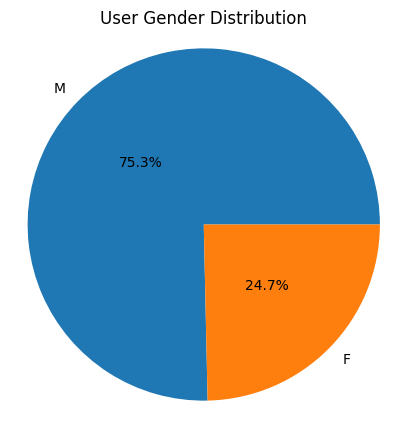

In [33]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(5, 5))
plt.pie(x, center=(0, 0), radius=1.5, labels=['M','F'], autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()

- From the above graph, **who have rated the movies, 75% are Males and 25% are Females.**

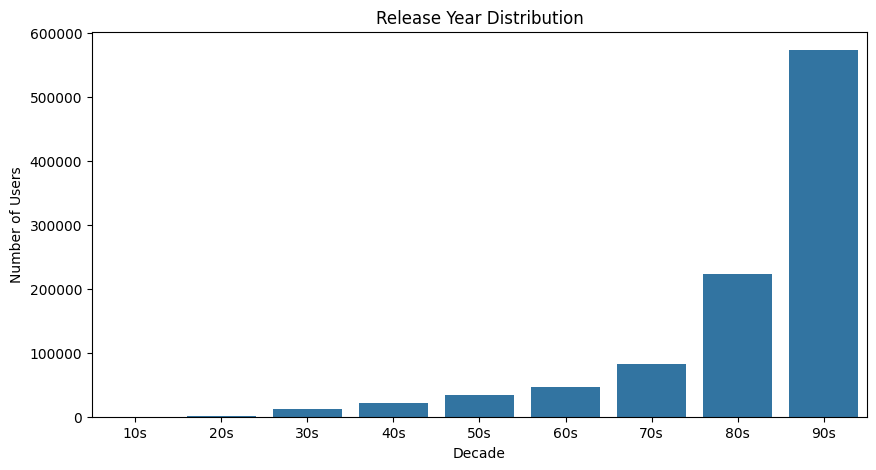

In [34]:
plt.figure(figsize=(10, 5))
sns.countplot(x='ReleaseYear', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

- **Most of the movies present in our dataset were released in 90s.**

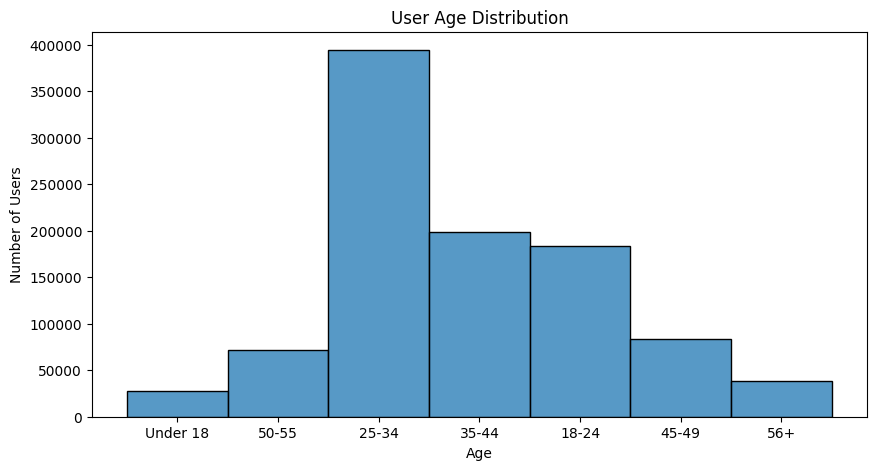

In [35]:
plt.figure(figsize=(10, 5))
sns.histplot(x='Age', data=data)
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

- Users of **25-34 age group** have watched and rated the most number of movies.

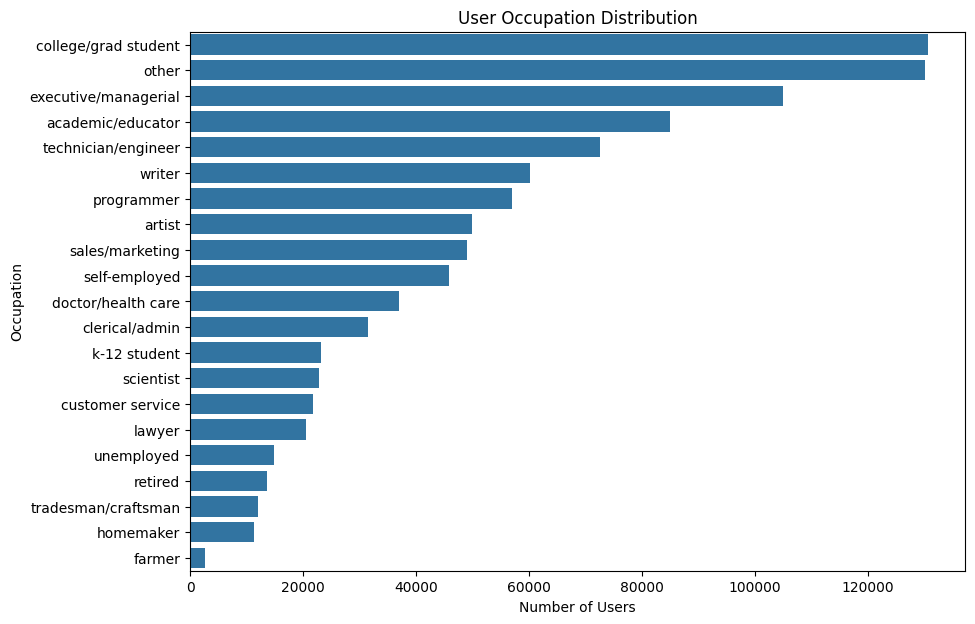

In [36]:
occupation_order = data['Occupation'].value_counts().index
plt.figure(figsize=(10, 7))
sns.countplot(y='Occupation', data=data, order=occupation_order)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

- Users belonging to **college/grad students** profession have watched and rated the most movies.

In [37]:
avg_user_ratings = data[['UserID','Rating']].groupby('UserID').mean()

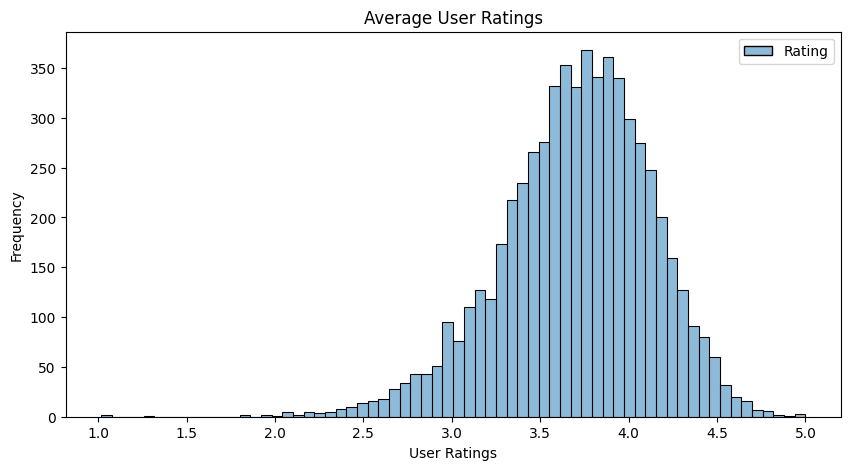

In [38]:
fig = plt.figure(figsize = (10, 5))
sns.histplot(data=avg_user_ratings, color = 'blue', alpha = 0.5)
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')
plt.show()

- **Most user ratings cluster around 3.5 to 4.0**, indicating average to slightly above-average satisfaction.
- Few ratings are at the very low (1.0-2.0) or very high (4.5-5.0) ends, reflecting cautious or moderate reviewing tendencies.

In [39]:
movies_rating_count = data.groupby('Title')['Rating'].count().reset_index(name = 'TotalRatingCount')
top10_movies=movies_rating_count.sort_values(by='TotalRatingCount',ascending=False).head(10)
top10_movies

,Title,TotalRatingCount
125,American Beauty,3428
3099,Star Wars: Episode IV - A New Hope,2991
3100,Star Wars: Episode V - The Empire Strikes Back,2990
3101,Star Wars: Episode VI - Return of the Jedi,2883
1761,Jurassic Park,2672
2843,Saving Private Ryan,2653
3238,Terminator 2: Judgment Day,2649
2075,"Matrix, The",2590
256,Back to the Future,2583
2936,"Silence of the Lambs, The",2578


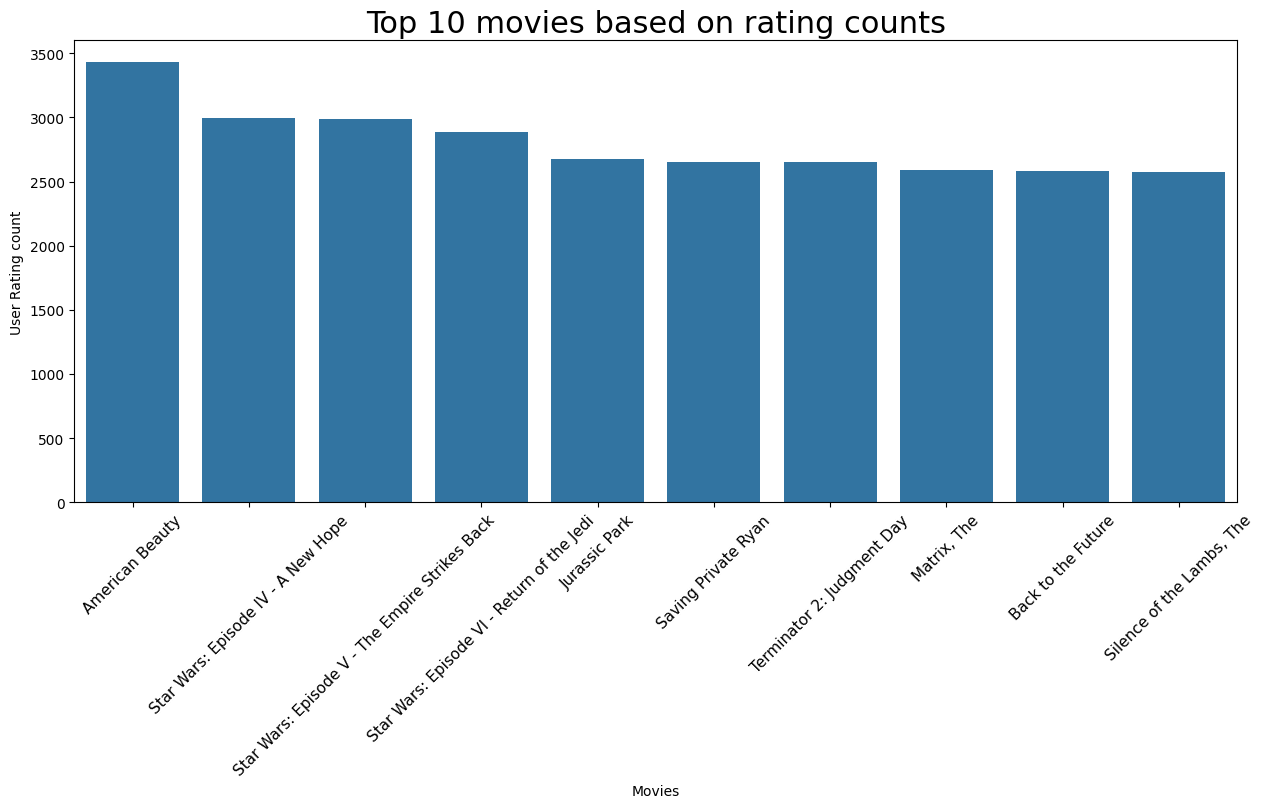

In [40]:
plt.figure(figsize=(15,6))
ax=sns.barplot(x="Title", y="TotalRatingCount", data=top10_movies)
plt.xticks(rotation=45, fontsize=11)
plt.title('Top 10 movies based on rating counts',fontsize = 22)
plt.xlabel('Movies',fontsize = 10)
plt.ylabel('User Rating count', fontsize = 10)
plt.show()

- The movie with maximum no. of ratings is **'American Beauty'.**

In [41]:
# Create a DataFrame of genres
genres_df = pd.get_dummies(movies_df['Genres'].apply(pd.Series).stack()).groupby(level=0).sum()
genres_df.head()

,,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
# considering all the genre columns for the test
test = genres_df.sum(axis = 0)
test=test.iloc[1:]
print(test)

Action          501
Adventure       282
Animation       104
Children's      249
Comedy         1189
Crime           210
Documentary     124
Drama          1582
Fantasy          62
Film-Noir        44
Horror          340
Musical         113
Mystery         105
Romance         462
Sci-Fi          265
Thriller        488
War             139
Western          68
dtype: int64


In [43]:
print(type(pd.to_numeric(test)))
print(type(test.to_numpy().reshape(len(test),)[0]))
test2 = test.to_numpy().reshape(18,)

<class 'pandas.core.series.Series'>
<class 'numpy.int64'>


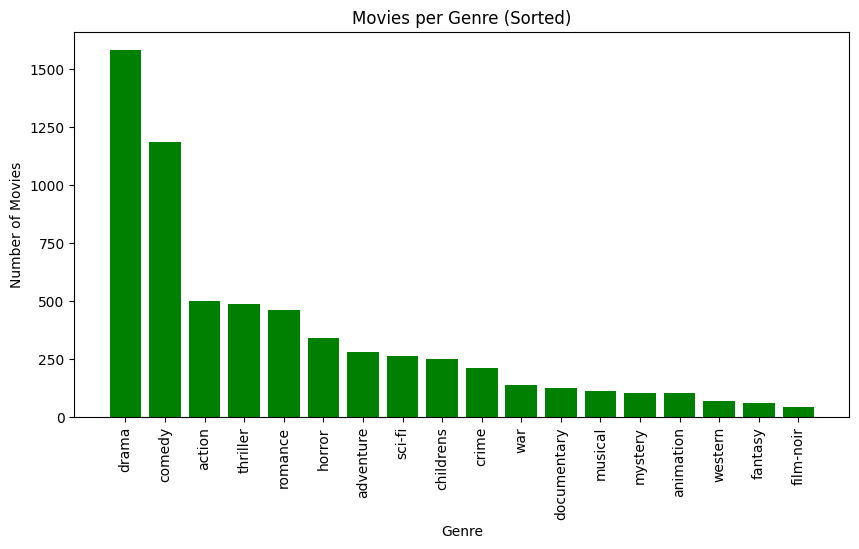

In [44]:
genre_list=['action', 'adventure','animation', 'childrens', 'comedy', 'crime',
                'documentary', 'drama','fantasy', 'film-noir', 'horror', 'musical',
                            'mystery', 'romance', 'sci-fi','thriller', 'war', 'western']


# Sort 'test2' and 'genre_list' in descending order of 'test2'
sorted_indices = np.argsort(test2)[::-1]
test2_sorted = test2[sorted_indices]
genre_list_sorted = np.array(genre_list)[sorted_indices]

# Plot the sorted data
x = np.arange(len(test2_sorted))
plt.figure(figsize=(10, 5))
plt.bar(x, test2_sorted, color='g')
plt.xticks(x, genre_list_sorted, rotation='vertical')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Movies per Genre (Sorted)')
sns.set(font_scale=1.5)
plt.show()

- From the above plot, we can infer that most the movies in the dataset belongs to **Drama and Comedy** genres.

# **3. Recommendations systems**

In [45]:
matrix = pd.pivot_table(data,index='UserID',columns='Title',values='Rating',aggfunc='mean')
# matrix.head()

In [46]:
# Imputing 'NaN' values with Zero rating
matrix.fillna(0,inplace=True)

In [47]:
matrix.shape

(6040, 3640)

In [48]:
matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0


In [49]:
# Checking data sparsity
n_users = data['UserID'].nunique()
n_movies = data['MovieID'].nunique()
sparsity = round(1.0 - data.shape[0] / float( n_users * n_movies), 3)
print('The sparsity level of dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of dataset is 95.5%


## **3.1 Pearson Correlation:**
Correlation is a measure that tells how closely two variables move in the same or opposite direction. A positive value indicates that they move in the same direction (i.e. if one increases other increases), where as a negative value indicates the opposite.

The most popular correlation measure for numerical data is Pearson’s Correlation. This measures the degree of linear relationship between two numeric variables and lies between -1 to +1. It is represented by ‘r’.

- r = 1 means perfect positive correlation
- r = -1 means perfect negative correlation
- r = 0 means no linear correlation (note, it does not mean no correlation)

**We will take a movie name as an input from the user and see which other 5 (five) movies have maximum correlation with it.**

In [50]:
data[data['Title']=='Toy Story']

,MovieID,Title,Genres,Year,UserID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Datatime,ReleaseYear
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,1,5,978824268,F,Under 18,k-12 student,48067,2001-01-06 23:37:48,90s
1,1,Toy Story,"[Animation, Children's, Comedy]",1995,6,4,978237008,F,50-55,homemaker,55117,2000-12-31 04:30:08,90s
2,1,Toy Story,"[Animation, Children's, Comedy]",1995,8,4,978233496,M,25-34,programmer,11413,2000-12-31 03:31:36,90s
3,1,Toy Story,"[Animation, Children's, Comedy]",1995,9,5,978225952,M,25-34,technician/engineer,61614,2000-12-31 01:25:52,90s
4,1,Toy Story,"[Animation, Children's, Comedy]",1995,10,5,978226474,F,35-44,academic/educator,95370,2000-12-31 01:34:34,90s
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,1,Toy Story,"[Animation, Children's, Comedy]",1995,6022,5,956755763,M,25-34,technician/engineer,57006,2000-04-26 13:29:23,90s
2073,1,Toy Story,"[Animation, Children's, Comedy]",1995,6025,5,956812867,F,25-34,academic/educator,32607,2000-04-27 05:21:07,90s
2074,1,Toy Story,"[Animation, Children's, Comedy]",1995,6032,4,956718127,M,45-49,executive/managerial,55108,2000-04-26 03:02:07,90s
2075,1,Toy Story,"[Animation, Children's, Comedy]",1995,6035,4,956712849,F,25-34,academic/educator,78734,2000-04-26 01:34:09,90s


In [51]:
data.Title

,Title
0,Toy Story
1,Toy Story
2,Toy Story
3,Toy Story
4,Toy Story
...,...
996139,"Contender, The"
996140,"Contender, The"
996141,"Contender, The"
996142,"Contender, The"


In [52]:
# movie_name = input("Enter a movie name: ")
movie_name = 'Toy Story'

# Taking the ratings of that movie
movie_rating = matrix[movie_name]
movie_rating

,Toy Story
UserID,
1,5.0
10,5.0
100,0.0
1000,5.0
1001,4.0
...,...
995,0.0
996,4.0
997,4.0


In [53]:
# Finding similar movies
similar_movies = matrix.corrwith(movie_rating)

# Creating a dataframe
similar_movies_df = pd.DataFrame(similar_movies, columns=['Correlation'])

# Sorting the values based on correlation
similar_movies_df.sort_values('Correlation', ascending=False, inplace=True)

# Top 5 correlated movies.
similar_movies_df.iloc[1:, :].head()

,Correlation
Title,
Toy Story 2,0.487370
Aladdin,0.470753
"Lion King, The",0.411131
Groundhog Day,0.407547
"Bug's Life, A",0.402679


## **3.2 Cosine Similarty:**

Cosine similarity is a measure of similarity between two sequences of numbers. Those sequences are viewed as vectors in a higher dimensional space, and the cosine similarity is defined as the cosine of the angle between them, i.e. the dot product of the vectors divided by the product of their lengths.

The cosine similarity always belongs to the interval [-1,1]. For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1.

### **3.2.1 Item-Based Similarity:**

In [54]:
# Finding the similarity values between item-item using cosine_similarity
item_similarity = cosine_similarity(matrix.T)
item_similarity

array([[1.        , 0.07235746, 0.03701053, ..., 0.        , 0.12024178,
        0.02700277],
       [0.07235746, 1.        , 0.11528952, ..., 0.        , 0.        ,
        0.07780705],
       [0.03701053, 0.11528952, 1.        , ..., 0.        , 0.04752635,
        0.0632837 ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.04564448],
       [0.12024178, 0.        , 0.04752635, ..., 0.        , 1.        ,
        0.04433508],
       [0.02700277, 0.07780705, 0.0632837 , ..., 0.04564448, 0.04433508,
        1.        ]])

In [55]:
# Item-similarity Matrix
item_similarity_matrix = pd.DataFrame(item_similarity, index=matrix.columns, columns=matrix.columns)
item_similarity_matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


### **3.2.2 User-Based Similarity:**

In [56]:
# Finding the similarity values between user-user using cosine_similarity
user_similarity = cosine_similarity(matrix)
user_similarity

array([[1.        , 0.25531859, 0.12396703, ..., 0.15926709, 0.11935626,
        0.12239079],
       [0.25531859, 1.        , 0.25964457, ..., 0.16569953, 0.13332665,
        0.24845029],
       [0.12396703, 0.25964457, 1.        , ..., 0.20430203, 0.11352239,
        0.30693676],
       ...,
       [0.15926709, 0.16569953, 0.20430203, ..., 1.        , 0.18657496,
        0.18563871],
       [0.11935626, 0.13332665, 0.11352239, ..., 0.18657496, 1.        ,
        0.10827118],
       [0.12239079, 0.24845029, 0.30693676, ..., 0.18563871, 0.10827118,
        1.        ]])

In [57]:
# Item-similarity Matrix
user_similarity_matrix = pd.DataFrame(user_similarity, index=matrix.index, columns=matrix.index)
user_similarity_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.255319,0.123967,0.207800,0.139317,0.110320,0.121384,0.180226,0.103896,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.255319,1.000000,0.259645,0.280479,0.158703,0.112917,0.141985,0.432536,0.194915,0.102487,...,0.154412,0.186234,0.083739,0.125894,0.118558,0.146552,0.304806,0.165700,0.133327,0.248450
100,0.123967,0.259645,1.000000,0.306067,0.075736,0.110450,0.358686,0.237492,0.172872,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.280479,0.306067,1.000000,0.099117,0.047677,0.201722,0.355920,0.325966,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139317,0.158703,0.075736,0.099117,1.000000,0.164854,0.053887,0.150196,0.138602,0.134710,...,0.146270,0.026891,0.097011,0.119609,0.092234,0.109700,0.222119,0.103255,0.269952,0.178399


## **3.3 Nearest Neighbors:**

In [58]:
model_knn = NearestNeighbors(metric='cosine')
model_knn.fit(matrix.T)

NearestNeighbors(metric='cosine')

In [59]:
# The distances and indices are being calculated with neighbors being 6
distances, indices = model_knn.kneighbors(matrix.T, n_neighbors=3)

In [60]:
# The result dataframe consits of the different indices of movies based on the distance
result = pd.DataFrame(indices, columns=['Title1','Title2','Title3'])
result.head()

,Title1,Title2,Title3
0,0,735,416
1,1,807,72
2,2,1627,2529
3,3,1457,2169
4,4,26,726


In [61]:
# With this for loop replacing the indices in the 'result' dataframe with movie titles of that corresponding ones
result2 = result.copy()
for i in range(1, 4):
    mov = pd.DataFrame(matrix.T.index).reset_index()
    mov = mov.rename(columns={'index':f'Title{i}'})
    result2 = pd.merge(result2, mov, on=[f'Title{i}'], how='left')
    result2 = result2.drop(f'Title{i}', axis=1)
    result2 = result2.rename(columns={'Title':f'Title{i}'})
result2.head()

,Title1,Title2,Title3
0,"$1,000,000 Duck","Computer Wore Tennis Shoes, The",Blackbeard's Ghost
1,'Night Mother,"Cry in the Dark, A",Agnes of God
2,'Til There Was You,If Lucy Fell,Picture Perfect
3,"'burbs, The",Harry and the Hendersons,"Money Pit, The"
4,...And Justice for All,52 Pick-Up,Coma


In [62]:
# movie_name = input("Enter a movie name: ")
movie_name = 'Liar Liar'

# 3 nearest movies for the movie present in Title1.
result2.loc[result2['Title1']==movie_name]

,Title1,Title2,Title3
1887,Liar Liar,Mrs. Doubtfire,Ace Ventura: Pet Detective


## **3.4 Matrix Factorization(Using cmfrec Library):**

In [63]:
# Creating a pivot table of movie titles and userid and ratings are taken as values
rm = data.pivot(index= 'UserID', columns= 'MovieID', values = 'Rating').fillna(0)
rm.head()

MovieID,1,10,100,1000,1002,1003,1004,1005,1006,1007,...,99,990,991,992,993,994,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
rm_raw = data[['UserID', 'MovieID', 'Rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']

# Lib requires specific column names
rm_raw.head()

,UserId,ItemId,Rating
0,1,1,5
1,6,1,4
2,8,1,4
3,9,1,5
4,10,1,5


In [65]:
print(rm_raw.shape)
print("No.of Users:",len(rm_raw['UserId'].unique()))
print("No.of Items:",len(rm_raw['ItemId'].unique()))

(996144, 3)
No.of Users: 6040
No.of Items: 3682


- An instance of the CMF model is created with various hyperparameters:

 - **method="als":** Specifies the alternating least squares (ALS) optimization method, commonly used for matrix factorization in recommendation systems.

 - **k=2:** Sets the number of latent factors to 2, determining the dimensionality of the latent factor space.

 - **lambda_=0.1:** Sets the regularization strength to 0.1. Regularization is used to prevent overfitting in the model.

 - **user_bias=False:** Indicates that user bias terms are not included in the model. User bias represents a user's overall rating tendency.

 - **item_bias=False:** Excludes item bias terms in the model. Item bias represents an item's overall rating tendency.

 - **verbose=False:** Suppresses verbose output, controlling whether the model's training progress is displayed.

In [66]:
model = CMF(k = 2, lambda_ = 0.1, verbose = False, user_bias= False, item_bias=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [67]:
# model.A_ gives the embeddings of Users and model.B_ gives the embeddings of Items
model.A_.shape, model.B_.shape

((6040, 2), (3682, 2))

In [68]:
# Average rating and Global Mean
rm_raw.Rating.mean(), model.glob_mean_

(3.57998542379415, 3.5799853801727295)

In [69]:
# Calculating the predicted ratings
rm__ = np.dot(model.A_, model.B_.T) + model.glob_mean_

In [70]:
# Calculating rmse value
rmse = mean_squared_error(rm.values[rm > 0], rm__[rm > 0], squared=False)
print('Root Mean Squared Error : {:.3f}'.format(rmse))

Root Mean Squared Error : 1.391


In [71]:
# Calculating mape value
mape = mean_absolute_percentage_error(rm.values[rm>0],rm__[rm>0])
print('Mean Absolute Percentage Error : {:.3f}'.format(mape))

Mean Absolute Percentage Error : 0.416


- **The rmse is 1.391 and mape is 0.416 for matrix factorization.**

In [72]:
def topN(self, user, n):
    # Compute predictions for the specified user
    user_predictions = np.dot(self.A_[user, :], self.B_.T) + self.glob_mean_

    # Get top N item indices with the highest predicted ratings
    top_items_indices = np.argsort(user_predictions)[-n:][::-1]

    return top_items_indices

In [73]:
# Getting top 10 recommended items for user 1
user = 1
top_10_items = topN(model, user, n=10)
print("Top 10 recommended items for user {}: {}".format(user, top_10_items))

Top 10 recommended items for user 1: [1308 2687 3622  827 2602  619 3087 3551 3279 3131]


In [74]:
# Retrieve corresponding item titles
top_10_titles = [data['Title'][i] for i in top_10_items]

print("Top 10 recommended items for user {}: {}".format(user, top_10_titles))

Top 10 recommended items for user 1: ['Toy Story', 'Jumanji', 'Father of the Bride Part II', 'Toy Story', 'Jumanji', 'Toy Story', 'Grumpier Old Men', 'Father of the Bride Part II', 'Waiting to Exhale', 'Grumpier Old Men']


### **3.4.1 Embeddings for item-item similarity:**

In [75]:
# Get item embeddings
item_embeddings = model.B_

# Compute similarity matrix
item_similarity = cosine_similarity(item_embeddings).round(2)
print("Item-Item Similarity Matrix:\n", item_similarity)

Item-Item Similarity Matrix:
 [[ 1.   -0.16 -0.34 ...  0.78  0.98  0.9 ]
 [-0.16  1.    0.98 ...  0.49  0.03  0.29]
 [-0.34  0.98  1.   ...  0.32 -0.16  0.11]
 ...
 [ 0.78  0.49  0.32 ...  1.    0.88  0.98]
 [ 0.98  0.03 -0.16 ...  0.88  1.    0.97]
 [ 0.9   0.29  0.11 ...  0.98  0.97  1.  ]]


In [76]:
item_similarity_matrix=pd.DataFrame(item_similarity,index=rm_raw['ItemId'].unique(),columns=rm_raw['ItemId'].unique())
item_similarity_matrix.head() #Item similarity matrix using the embeddings from matrix factorization

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,1.00,-0.16,-0.34,-0.47,-0.30,0.97,0.10,-0.21,-0.47,0.33,...,-0.05,-0.09,-0.71,-0.71,0.70,0.56,0.99,0.78,0.98,0.90
2,-0.16,1.00,0.98,0.95,0.99,0.10,0.97,1.00,0.95,0.88,...,0.99,1.00,0.81,0.81,0.59,0.73,-0.31,0.49,0.03,0.29
3,-0.34,0.98,1.00,0.99,1.00,-0.09,0.90,0.99,0.99,0.78,...,0.96,0.97,0.90,0.90,0.43,0.59,-0.48,0.32,-0.16,0.11
4,-0.47,0.95,0.99,1.00,0.98,-0.23,0.83,0.96,1.00,0.68,...,0.91,0.92,0.95,0.95,0.30,0.47,-0.60,0.19,-0.29,-0.04
5,-0.30,0.99,1.00,0.98,1.00,-0.05,0.92,1.00,0.98,0.80,...,0.97,0.98,0.89,0.88,0.47,0.62,-0.44,0.36,-0.12,0.15


In [77]:
movie_name='3945'
movie_rating=item_similarity_matrix[movie_name]
print(movie_rating)

1      -0.71
2       0.81
3       0.90
4       0.95
5       0.89
        ... 
3948    0.19
3949   -0.81
3950   -0.11
3951   -0.56
3952   -0.33
Name: 3945, Length: 3682, dtype: float32


In [78]:
# Finding similar movies
similar_movies=item_similarity_matrix.corrwith(movie_rating)

similar_movies_df=pd.DataFrame(similar_movies,columns=['Correlation'])
similar_movies_df.sort_values('Correlation',ascending=False,inplace=True)

# Top 5 correlated movies
similar_movies_df.iloc[1:, :].head()

,Correlation
2368,0.999995
179,0.999981
3374,0.999981
667,0.999976
3946,0.999976


In [79]:
similar_movies_df1=similar_movies_df.copy()
similar_movies_df1 = similar_movies_df1.reset_index().rename(columns={'index':'MovieID'}).head(6)
# print(similar_movies_df1.head())

df2=data[['MovieID','Title']].copy()
df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True,inplace=True)
# print(df2.head())

similar_movies = pd.merge(df2, similar_movies_df1, on = 'MovieID', how = 'inner')
similar_movies

,MovieID,Title,Correlation
0,179,Mad Love,0.999981
1,667,Bloodsport 2,0.999976
2,2368,King Kong Lives,0.999995
3,3374,Daughters of the Dust,0.999981
4,3945,Digimon: The Movie,1.000000
5,3946,Get Carter,0.999976


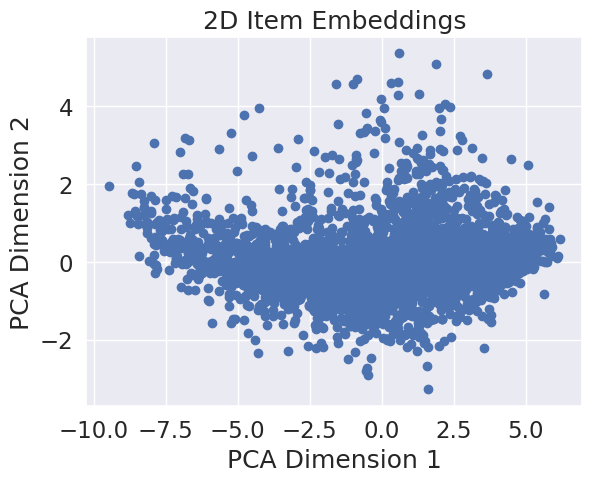

In [80]:
# Reduce item embeddings to 2D
pca = PCA(n_components=2)
item_embeddings_2d = pca.fit_transform(item_embeddings)

# Plot item embeddings
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1])
plt.title("2D Item Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

- Items appear **densely clustered around the center**, suggesting that many items share similar features or user interaction patterns.
- Sparse points away from the center indicate unique items or outliers that may differ significantly from the majority.

### **3.4.2 Embeddings for user-user similarity:**

In [81]:
# Get user embeddings
user_embeddings = model.A_

# Compute similarity matrix
user_similarity = cosine_similarity(user_embeddings).round(2)
print("User-User Similarity Matrix:\n", user_similarity)

User-User Similarity Matrix:
 [[ 1.    1.    0.63 ... -0.39  1.    0.59]
 [ 1.    1.    0.61 ... -0.42  1.    0.57]
 [ 0.63  0.61  1.   ...  0.47  0.61  1.  ]
 ...
 [-0.39 -0.42  0.47 ...  1.   -0.41  0.51]
 [ 1.    1.    0.61 ... -0.41  1.    0.57]
 [ 0.59  0.57  1.   ...  0.51  0.57  1.  ]]


In [82]:
user_similarity_matrix=pd.DataFrame(user_similarity,index=matrix.index,columns=matrix.index)
user_similarity_matrix.head() #User similarity matrix using the embeddings from matrix factorization

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.00,1.00,0.63,-0.04,1.00,0.58,0.29,-0.92,-0.79,-0.83,...,-0.48,0.99,0.22,-0.05,0.92,0.58,1.00,-0.39,1.00,0.59
10,1.00,1.00,0.61,-0.07,0.99,0.56,0.26,-0.93,-0.81,-0.85,...,-0.51,0.99,0.20,-0.07,0.91,0.56,1.00,-0.42,1.00,0.57
100,0.63,0.61,1.00,0.75,0.70,1.00,0.92,-0.28,-0.03,-0.10,...,0.37,0.51,0.90,0.75,0.89,1.00,0.62,0.47,0.61,1.00
1000,-0.04,-0.07,0.75,1.00,0.05,0.79,0.95,0.43,0.64,0.59,...,0.89,-0.19,0.97,1.00,0.36,0.79,-0.06,0.94,-0.07,0.78
1001,1.00,0.99,0.70,0.05,1.00,0.66,0.38,-0.88,-0.73,-0.78,...,-0.40,0.97,0.31,0.05,0.95,0.65,0.99,-0.31,0.99,0.66


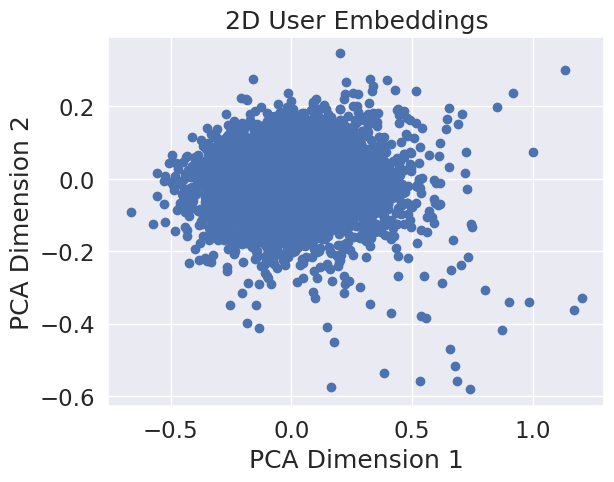

In [83]:
# Reduce user embeddings to 2D
pca = PCA(n_components=2)
user_embeddings_2d = pca.fit_transform(user_embeddings)

# Plot user embeddings
plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1])
plt.title("2D User Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

- Users appear **densely clustered around the center**, suggesting that most of the users share similar features.

## **3.5 User-Based Approach(optional):**

In [84]:
# Taking 6 movies names in random
mov_name = ['Hamlet', 'Dumb & Dumber', 'Ace Ventura: Pet Detective', 'Home Alone','Robin Hood','It Happened One Night']

In [85]:
# Finding the MovieID's for the above movies
mov_id = []
for movie in mov_name:
    # Check if the movie exists in the dataset
    matching_rows = data[data['Title'] == movie]
    if not matching_rows.empty:
        id = matching_rows['MovieID'].iloc[0]
        mov_id.append(id)
        print(f"MovieID for '{movie}': {id}")
    else:
        print(f"Movie '{movie}' not found in the dataset.")

MovieID for 'Hamlet': 1411
MovieID for 'Dumb & Dumber': 231
MovieID for 'Ace Ventura: Pet Detective': 344
MovieID for 'Home Alone': 586
MovieID for 'Robin Hood': 3034
MovieID for 'It Happened One Night': 905


In [86]:
# Give random user ratings for the movies
mov_rating = [5, 3, 2, 1, 4, 3]

In [87]:
user_choices = pd.DataFrame({'MovieID': mov_id, 'Title': mov_name, 'Rating': mov_rating})
user_choices.sort_values(by='MovieID', inplace = True)

In [88]:
# Finding other users who watched the same movies
other_users = data[data['MovieID'].isin(user_choices['MovieID'].values)]
if other_users.empty:
    print("No other users have rated the selected movies.")
else:
    # Group by UserID for movies in common
    common_movies = other_users.groupby('UserID')

    # Sort users by the count of common movies
    common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True)

    # Take the top 100 users
    top_users = common_movies[:100]

    # Calculating Pearson Correlation
    pearson_corr = {}
    for user_id, movies in top_users:
        movies = movies.sort_values(by='MovieID')
        movie_list = movies['MovieID'].values

        # Ratings for common movies
        new_user_ratings = user_choices[user_choices['MovieID'].isin(movie_list)]['Rating'].values
        user_ratings = movies[movies['MovieID'].isin(movie_list)]['Rating'].values

        # Only calculate correlation if sufficient data exists
        if len(new_user_ratings) > 1 and len(user_ratings) > 1:
            corr = pearsonr(new_user_ratings, user_ratings)
            if not pd.isna(corr[0]):  # Check for valid correlation
                pearson_corr[user_id] = corr[0]

In [89]:
# Creating a DataFrame for Similarity Index
pearson_df = pd.DataFrame(columns=['UserID', 'Similarity Index'], data=pearson_corr.items())
pearson_df = pearson_df.sort_values(by='Similarity Index', ascending=False)[:10]

In [90]:
# Merge with original data for recommendations
users_rating = pearson_df.merge(data, on='UserID', how='inner')

In [91]:
# Calculate Weighted Rating
users_rating['Weighted Rating'] = users_rating['Rating'] * users_rating['Similarity Index']
users_rating = users_rating[['UserID', 'MovieID', 'Rating', 'Similarity Index', 'Weighted Rating']]

In [92]:
# Aggregate Weighted Rating and Similarity Index by MovieID
grouped_ratings = users_rating.groupby('MovieID').sum()[['Similarity Index', 'Weighted Rating']]

In [93]:
# Calculate average recommendation score
recommend_movies = pd.DataFrame()
recommend_movies['avg_recommend_score'] = grouped_ratings['Weighted Rating'] / grouped_ratings['Similarity Index']
recommend_movies['MovieID'] = grouped_ratings.index
recommend_movies = recommend_movies.reset_index(drop=True)

In [94]:
# Filter movies with avg_recommend_score >= 4.5
recommend_movies = recommend_movies[recommend_movies['avg_recommend_score'] >= 4.5]

In [95]:
# Recommend top 10 movies
recommendations = data[data['MovieID'].isin(recommend_movies['MovieID'])][['MovieID', 'Title']]
if len(recommendations) > 10:
    recommendations = recommendations.sample(10)

print("Top Recommended Movies:")
print(recommendations)

Top Recommended Movies:
       MovieID                            Title
332769    1235                 Harold and Maude
298546    1197              Princess Bride, The
226724     923                     Citizen Kane
837676    3147                  Green Mile, The
320003    1219                           Psycho
293289    1193  One Flew Over the Cuckoo's Nest
947341    3683                     Blood Simple
372489    1292                      Being There
612666    2288                       Thing, The
14028       29       City of Lost Children, The


# **4. The sparse 'row' matrix representation for the following dense matrix -[[1 0][3 7]]**

In [96]:
from scipy.sparse import csr_matrix

# creating dense matrix
A = np.array([[1,0],[3,7]])

# converting to sparse matrix (CSR method)
S = csr_matrix(A)

print(S)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


# **5. Summary:**
- From the above graph, **who have rated the movies, 75% are Males and 25% are Females.**
- **Most of the movies present in our dataset were released in 90s.**
- Users of **25-34 age group** have watched and rated the most number of movies.
- Users belonging to **college/grad students** profession have watched and rated the most movies.
- **Most user ratings cluster around 3.5 to 4.0**, indicating average to slightly above-average satisfaction. Few ratings are at the very low (1.0-2.0) or very high (4.5-5.0) ends, reflecting cautious or moderate reviewing tendencies.
- The movie with maximum no. of ratings is **'American Beauty'.**
- From the above plot, we can infer that most the movies in the dataset belongs to **Drama and Comedy** genres.
- **The rmse is 1.391 and mape is 0.416 for matrix factorization.**


- The embeddings can be used for:
  - Clustering to group similar items.
  - Content-based filtering in recommendation systems by finding similar items for a user.